# Проект: Линейные модели в машинном обучении

## Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

## Цель исследования

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Задачи исследования

Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

Нужно собрать данные по клиентам по следующим группам:
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.

Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Руководство одобрило описание решения, и вам, как специалисту по DS, нужно его реализовать.

## Исходные данные

Данные для работы находятся в нескольких таблицах:

**market_file.csv** - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


**market_money.csv** - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.


**market_time.csv** - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.


**money.csv** - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

## Раздел 1. Изучение общей информации

###  1. Загрузка библиотек и функций

In [1]:
# Импортируем необходимые бибилиотеки и функции
!pip install phik -q
!pip install scikit-learn --upgrade -q
!pip install shap==0.44.0 -q

import pandas as pd
import numpy as np
import re
import phik
import os
import shap
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# создание констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

##  2. Загрузка и изучение данных

In [2]:
# Проверяем пути к файлам на их наличие

pth1 = '/datasets/market_file.csv'
pth2 = '/datasets/market_money.csv'
pth3 = '/datasets/market_time.csv'
pth4 = '/datasets/money.csv'

if os.path.exists(pth1):
    query_1 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    query_1 = pd.read_csv(pth2)
elif os.path.exists(pth3):
    query_1 = pd.read_csv(pth3)
elif os.path.exists(pth4):
    query_1 = pd.read_csv(pth4)
else:
    print('Указанный путь к файлу не найден')

In [3]:
# Загружаем датафреймы
market_file = pd.read_csv(pth1)
market_money = pd.read_csv(pth2)
market_time = pd.read_csv(pth3)
# в датафрейме money определяем разделитель ';', меняем запятые на точки в цифрах,
money = pd.read_csv(pth4, sep=';',decimal = ',')

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 1 <a class="tocSkip"></h3>
    
Импортировал необходимые библиотеки и функции, задал константы.

Использовал проверку директорий с помощью библиотеки os, после чего загрузил датафреймы.
    
При создании датафрейма из файла money.csv указывал разделитель ';', после заменил запятые на точки в столбце 'Прибыль' и поменял тип данных на float.    
</div>

## Раздел 2. Предобработка данных

### 1. Создание собственных функций

In [4]:
# функция проверки пропусков в столбцах датафрейма
def na_search (dataframe):
    print(f'В датафрейме {[x for x in globals() if globals()[x] is dataframe][0]}')
    count = 0
    for i in dataframe.columns:
        if dataframe[i].isna().sum() != 0:
            print(f'кол-во пропусков в столбцe {i} - {dataframe[i].isna().sum()}')    
            count +=1
    if count == 0:
        print('пропусков в данных нет')
    else:
        print('в остальных столбцах пропусков в данных нет')
    print()

In [5]:
# функция приведения названий столбцов к нижнему регистру и удаления пробелов в начале и конце ячеек
def snake_cols(dataframe):
    dataframe.columns = [re.sub(r'(?<!^)(?=[A-Z])','_',i).replace(' ','_').lower().strip() for i in dataframe.columns]

In [6]:
# функция приведения текстовых столбцов к нижнему регистру и удаления пробелов в начале и конце ячеек
def snake_text(dataframe):
    for i in dataframe.columns:
        if dataframe[i].dtype == 'object':
            dataframe[i] = dataframe[i].str.replace(' ','_').str.lower().str.strip()

In [7]:
# функция проверки уникальных значений в текстовых столбцах
def unique_textcolumns (dataframe):
    for i in dataframe.columns:
        if dataframe[i].dtype == 'object':
            print(dataframe[i].value_counts())
            print()

<div class="alert alert-block alert-info">
    
<h3> Подвывод   <a class="tocSkip"></h3>
    
Создал четыре функции для облегчения предобработки данных и упрощения кода
    
</div>

### 2. Проверка на пропуски, преобразование типов данных, удаление дубликатов

In [8]:
# проверяем датафреймы на пропуски с помощью написанной функции
na_search(market_file)
na_search(market_money)
na_search(market_time)
na_search(money)

В датафрейме market_file
пропусков в данных нет

В датафрейме market_money
пропусков в данных нет

В датафрейме market_time
пропусков в данных нет

В датафрейме money
пропусков в данных нет



In [9]:
# приведем название столбцов в датафреймах к змеиному регистру 
snake_cols(market_file)
snake_cols(market_money)
snake_cols(market_time)
snake_cols(money)

In [10]:
# приводим текстовые значения в датафреймах к нижнему регистру, удаляем пробелы в начале и конце
snake_text(market_file)
snake_text(market_money)
snake_text(market_time)
snake_text(money)

In [11]:
# взглянем на market_file
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандартт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандартт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандартт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2


In [12]:
# выводим уникальные значения в текстовых столбцах
unique_textcolumns(market_file)

прежний_уровень    802
снизилась          498
Name: покупательская_активность, dtype: int64

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

товары_для_детей                        330
домашний_текстиль                       251
косметика_и_аксесуары                   223
техника_для_красоты_и_здоровья          184
мелкая_бытовая_техника_и_электроника    174
кухонная_посуда                         138
Name: популярная_категория, dtype: int64



In [13]:
# исправляем ошибки в столбце 'тип_сервиса'
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт','стандарт')

In [14]:
# проверяем
unique_textcolumns(market_file)

прежний_уровень    802
снизилась          498
Name: покупательская_активность, dtype: int64

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

да     962
нет    338
Name: разрешить_сообщать, dtype: int64

товары_для_детей                        330
домашний_текстиль                       251
косметика_и_аксесуары                   223
техника_для_красоты_и_здоровья          184
мелкая_бытовая_техника_и_электроника    174
кухонная_посуда                         138
Name: популярная_категория, dtype: int64



In [15]:
# проверяем на явные дубликаты
print(f'Количество явных дубликатов - {market_file.duplicated().sum()}')

Количество явных дубликатов - 0


In [16]:
# выводим Id в индекс
market_file= market_file.set_index('id')

In [17]:
# проверяем на явные дубликаты
print(f'Количество явных дубликатов - {market_file.duplicated().sum()}')

Количество явных дубликатов - 11


In [18]:
# взглянем на market_money
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [19]:
# проверяем на явные дубликаты
print(f'Количество явных дубликатов - {market_money.duplicated().sum()}')

Количество явных дубликатов - 0


In [20]:
# преобразуем таблицу - создаем отдельные столбцы для каждого периода
market_money = pd.pivot_table(market_money, index='id', columns='период', values='выручка')
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   предыдущий_месяц     1300 non-null   float64
 1   препредыдущий_месяц  1300 non-null   float64
 2   текущий_месяц        1300 non-null   float64
dtypes: float64(3)
memory usage: 40.6 KB


период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [21]:
# проверяем на явные дубликаты
print(f'Количество явных дубликатов - {market_money.duplicated().sum()}')

Количество явных дубликатов - 21


In [22]:
# взглянем на market_money
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [23]:
# выводим уникальные значения в текстовых столбцах
unique_textcolumns(market_time)

текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64



In [24]:
# исправляем ошибки
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц','предыдущий_месяц')

In [25]:
# преобразуем таблицу - создаем отдельные столбцы для каждого периода
market_time = pd.pivot_table(market_time, index='id', columns='период', values='минут')
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   предыдущий_месяц  1300 non-null   int64
 1   текущий_месяц     1300 non-null   int64
dtypes: int64(2)
memory usage: 30.5 KB


период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [26]:
# взглянем на market_money
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [27]:
# проверяем на явные дубликаты
print(f'Количество явных дубликатов - {money.duplicated().sum()}')

Количество явных дубликатов - 0


In [28]:
# выводим Id в индекс
money= money.set_index('id')

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 2  <a class="tocSkip"></h3>
    
Провел предобработку данных с использованием собственных функций.

Проверил категориальные столбцы на уникальные значения. Выявил ошибки, исправил их.
    
Преобразовал датафреймы market_time и market_money: создал отдельные столбцы для каждого периода.
    
Выявил дубликаты, но только после вывода ID в индекс, поэтому удалять их не стал. Проверю дополнительно на дубликаты после объединения таблиц.
    
Проверил данные повторно: данные очищены.
    
</div>

## Раздел 3. Исследовательский анализ данных

### 1. Создание собственных функций

In [29]:
# создание функции построения графиков для количественных и категориальных столбцов датафрейма
def stat_plot(dataframe):
    k = 0
    cols = dataframe.select_dtypes(include='number').columns.tolist()
    n = len(cols)
    plt.figure(figsize=(15, 6*n))
    for i in cols:
        k += 1
        plt.subplot(n,2,k)
        dataframe[i].plot(kind='hist', bins=50)
        plt.title('Гистограмма распределения значений столбца "' + i +'"')
        plt.xlabel('Значение столбца "' + i +'"')
        plt.ylabel('Частота встречаемости')
        k += 1
        plt.subplot(n,2,k)
        dataframe[i].plot(kind='box')
        plt.title('Диаграмма размаха значений столбца "' + i +'"')
        plt.ylabel('Значения столбца "' + i +'"')        
    plt.show()
   
    cols = dataframe.select_dtypes(exclude='number').columns.tolist()
    n = len(cols)
    plt.figure(figsize=(15, 6*n))
    for i in cols:        
        sns.catplot(data=market_file, y=i,  kind="count",palette="pastel", edgecolor=".6")
        plt.title('Гистограмма распределения значений столбца "' + i +'"')
        #plt.xlabel('Частота встречаемости')
        #plt.ylabel('Значение столбца "' + i +'"')             
    plt.show()    

### 2. Анализ каждой таблицы с данными

In [30]:
# вывод описательных статистик market_file
market_file.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


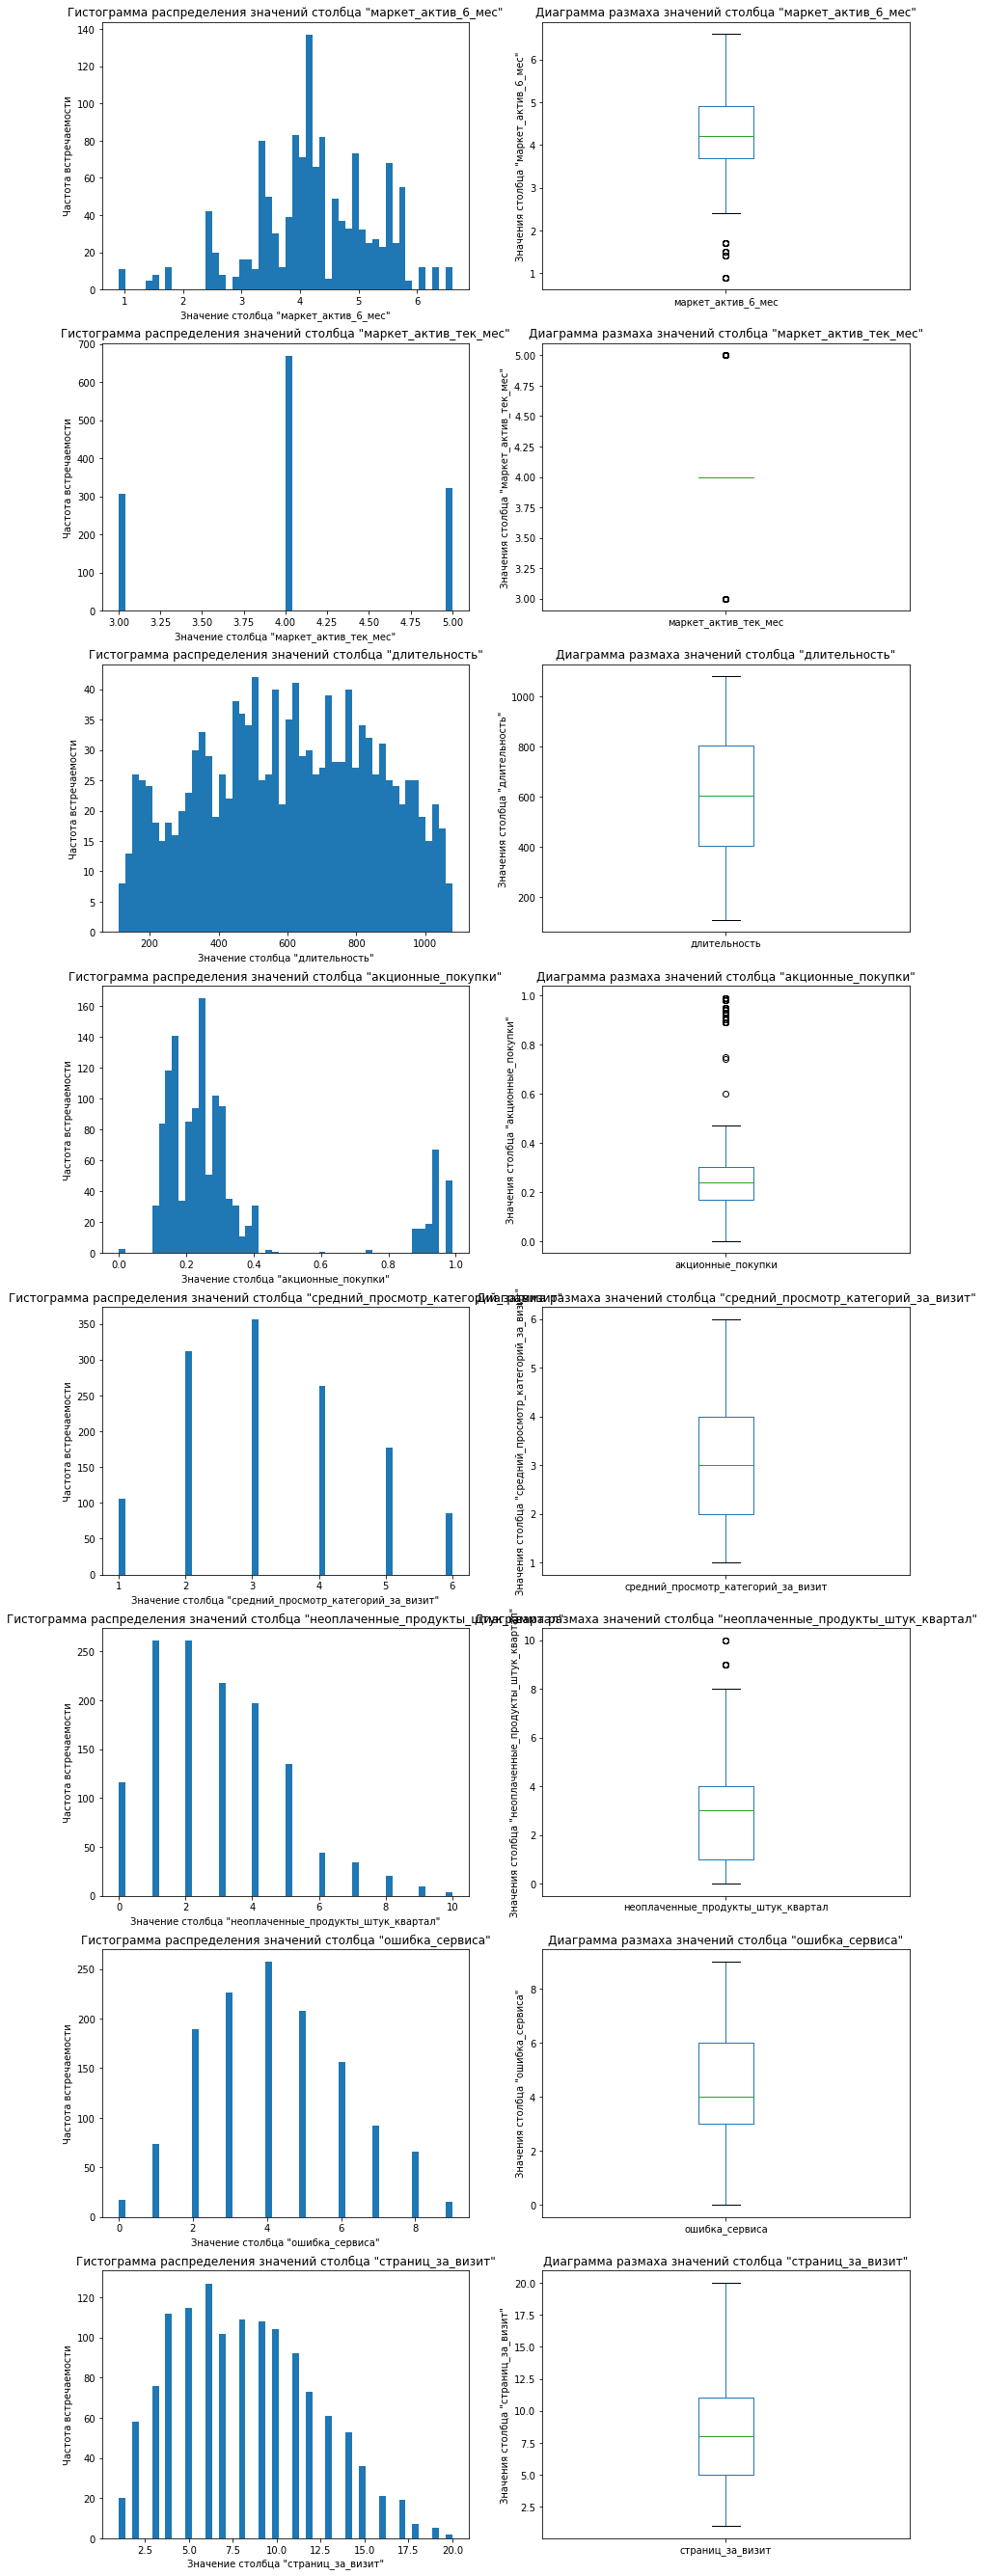

<Figure size 1080x1728 with 0 Axes>

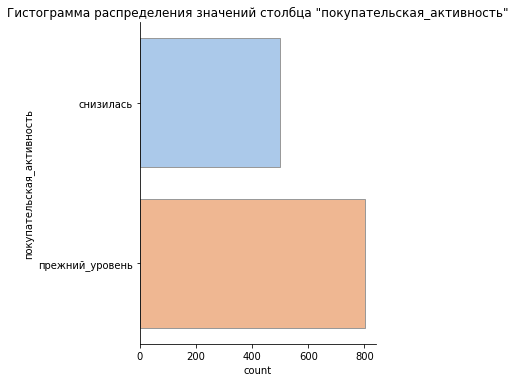

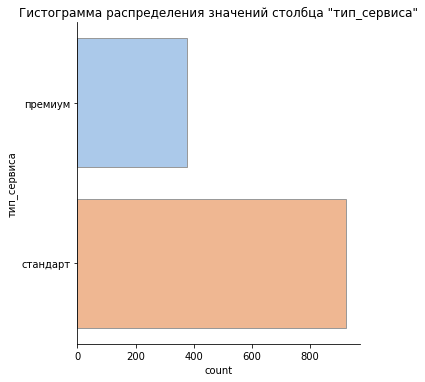

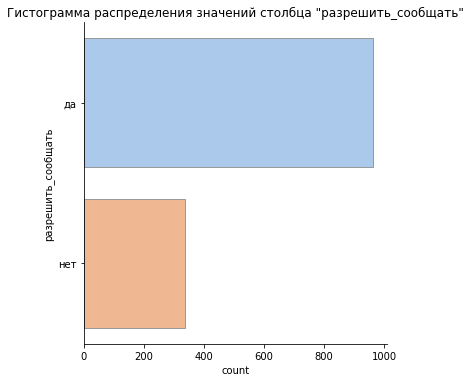

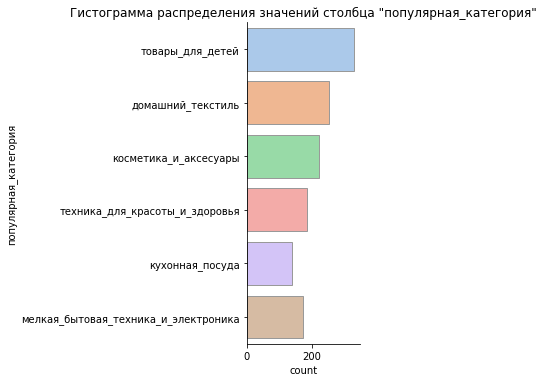

In [31]:
# строим гистограмму частотности распределения и ящик с усами для количественных столбцов и графики для категориальных
stat_plot(market_file)

<div class="alert alert-block alert-info">
    
<h3> Подвывод по анализу market_file  <a class="tocSkip"></h3>
    
Распределение гистограмм "маркет_актив_6_мес", "маркет_актив_тек_мес", "длительность", "средний_просмотр_категорий_за_визит", "неоплаченные_продукты_штук_квартал", "ошибка_сервиса" и "страниц_за_визит" являются ожидаемыми. 
   
Выбросы вниз для "маркет_актив_6_мес" объяснимы: есть пользователи с низкой активностью. Удалять их не будем.
   
Выбросы вверх для "неоплаченные_продукты_штук_квартал" также объяснимы: есть пользователи с 9 и 10 неоплаченными товарами. Удалять их не будем.
  
Гистограмма "акционные покупки" имеет два пика: скорее всего есть покупатели, которые предпочитают исключительно покупки по акциям. Это реально. 
    
Покупательская активность у большинства клиентов остается на прежнем уровне. С остальными будем работать дальше по проекту.
    
Количество клиентов с премиум обслуживанием более, чем в два раза больше, чем стандарт. Это адекватно.
    
Разрешить сообщать имеет объяснимые показатели - пользователи чаще разрешают присылать предложения.
    
Самые популярные категории - товары для детей и домашний текстиль.
    
</div>

In [32]:
# вывод описательных статистик market_money
market_money.describe()

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
count,1300.000000,1300.000000,1300.000000
mean,4936.920385,4825.206923,5314.960846
std,739.597997,405.979663,2939.708156
min,0.000000,0.000000,2758.700000
25%,4496.750000,4583.000000,4706.050000
50%,5005.000000,4809.000000,5179.950000
75%,5405.625000,5053.500000,5761.725000
max,6869.500000,5663.000000,106862.200000


In [33]:
# выведем выбросы
print(market_money.query(('предыдущий_месяц == 0')and('препредыдущий_месяц == 0')))
print(market_money.query('текущий_месяц > 10000'))

период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
id                                                          
215348               0.0                  0.0         3293.1
215357               0.0                  0.0         5986.3
215359               0.0                  0.0         4735.0
период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
id                                                          
215380            6077.0               5051.0       106862.2


In [34]:
# удаляем трех неактивных клиентов за предыдущие два месяца и один выброс
market_money = market_money.drop(index=[215348, 215357, 215359, 215380])

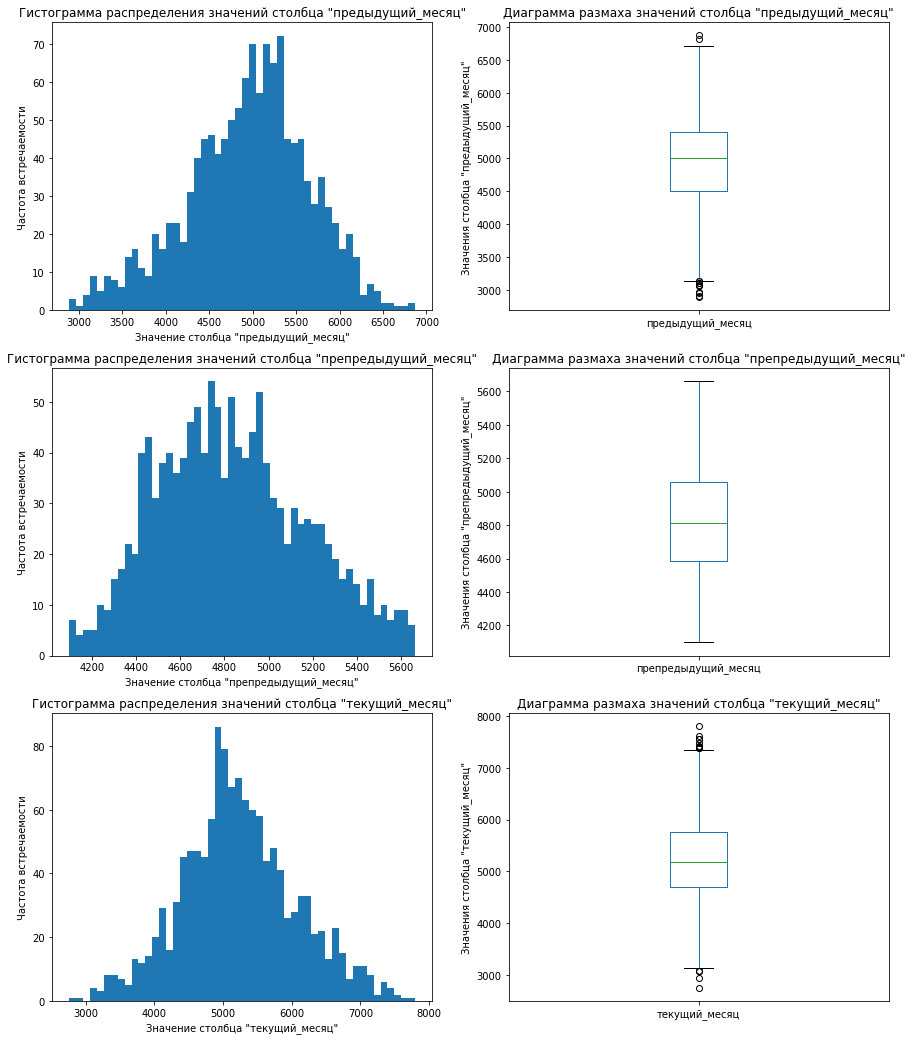

<Figure size 1080x0 with 0 Axes>

In [35]:
# строим гистограмму частотности распределения и ящик с усами с исключением выбросов
stat_plot(market_money)

<div class="alert alert-block alert-info">
    
<h3> Подвывод по анализу market_money  <a class="tocSkip"></h3>
    
Определил и удалил из датафреймов трех неактивных в предыдущие месяцы клиентов, а также одного клиента с выбросом вверх в текущем месяце.
    
После этого распределение гистограмм являются ожидаемыми с близким к нормальному распределением. 
   
Значения за пределами усов удалять не будем.    
</div>

In [36]:
# вывод описательных статистик market_time
market_time.describe()

период,предыдущий_месяц,текущий_месяц
count,1300.000000,1300.000000
mean,13.467692,13.204615
std,3.932029,4.220589
min,5.000000,4.000000
25%,11.000000,10.000000
50%,13.000000,13.000000
75%,17.000000,16.000000
max,23.000000,23.000000


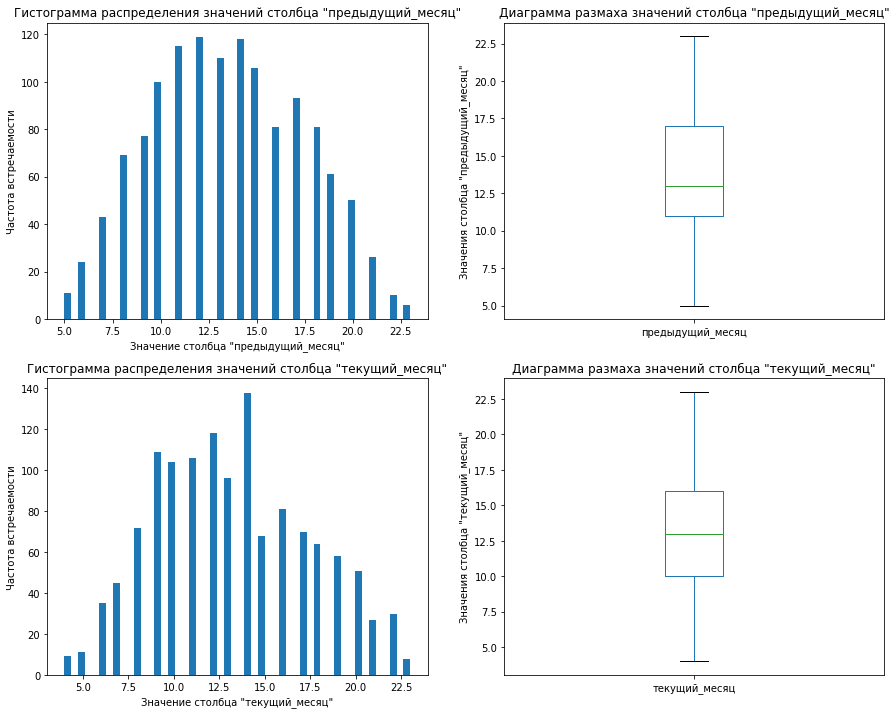

<Figure size 1080x0 with 0 Axes>

In [37]:
# строим гистограмму частотности распределения и ящик с усами для количественных столбцов
stat_plot(market_time)

<div class="alert alert-block alert-info">
    
<h3> Подвывод по анализу market_time  <a class="tocSkip"></h3>
    
Распределение гистограмм являются ожидаемыми с близким к нормальному распределением. 
   
Значений за пределами усов нет.    
</div>

In [38]:
# вывод описательных статистик money
money.describe()

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


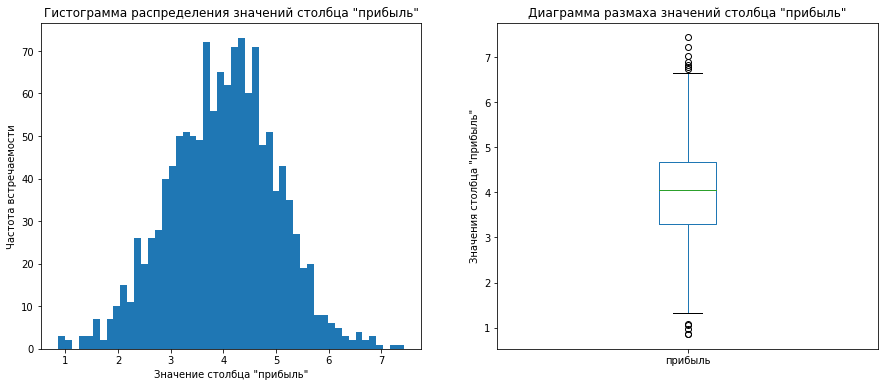

<Figure size 1080x0 with 0 Axes>

In [39]:
# строим гистограмму частотности распределения и ящик с усами
stat_plot(money)

<div class="alert alert-block alert-info">
    
<h3> Подвывод по анализу money  <a class="tocSkip"></h3>
    
Распределение гистограммы является ожидаемым и близким к нормальному. 
   
Значения за пределами усов объяснимы, удалять их не будем.    
</div>

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 3  <a class="tocSkip"></h3>
    
Провел исследовательский анализ данных с помощью собственных функций. Использовал статистический и графический методы анализа. 

В файле market_file распределение гистограмм "маркет_актив_6_мес", "маркет_актив_тек_мес", "длительность", "средний_просмотр_категорий_за_визит", "неоплаченные_продукты_штук_квартал", "ошибка_сервиса" и "страниц_за_визит" являются ожидаемыми. 
   
Есть выбросы вниз для "маркет_актив_6_мес", они объяснимы: есть пользователи с низкой активностью. Удалять их не будем.
   
Выбросы вверх для "неоплаченные_продукты_штук_квартал" также объяснимы: есть пользователи с 9 и 10 неоплаченными товарами. Удалять их не будем.
  
Гистограмма "акционные покупки" имеет два пика: скорее всего есть покупатели, которые предпочитают исключительно покупки по акциям. Это реально. 
    
По результатам анализа таблицы market_money определил и удалил из всех датафреймов трех неактивных в предыдущие месяцы клиентов, а также одного клиента с выбросом вверх в текущем месяце. После этого распределение гистограмм стали ожидаемыми с близким к нормальному распределением. Значения за пределами усов не удалял.    

Распределение гистограмм в таблицах market_time и money является ожидаемым и близким к нормальному. Значения за пределами усов не удалял.  
</div>

## Раздел 4. Объединение таблиц

In [40]:
# изменяем идентичные названия в датафреймах market_money и market_time на уникальные
market_money.columns = ['предыдущий_месяц_прибыль', 'препредыдущий_месяц_прибыль', 'текущий_месяц_прибыль']
market_time.columns = ['предыдущий_месяц_время', 'текущий_месяц_время']

In [41]:
# последовательно присоединяем две таблицы к market_file
market_file = market_file.join(market_money)
market_file = market_file.join(market_time)

In [42]:
# взглянем на получившийся датафрейм
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1300 non-null   object 
 1   тип_сервиса                          1300 non-null   object 
 2   разрешить_сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  ошибка_сервиса                       1300 non-null   int64  
 11  страниц_за_визит       

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_прибыль,препредыдущий_месяц_прибыль,текущий_месяц_прибыль,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,,
215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5,NaN,NaN,NaN,13,14
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [43]:
# проверяем датафрейм на пропуски с помощью написанной функции
na_search(market_file)

В датафрейме market_file
кол-во пропусков в столбцe предыдущий_месяц_прибыль - 4
кол-во пропусков в столбцe препредыдущий_месяц_прибыль - 4
кол-во пропусков в столбцe текущий_месяц_прибыль - 4
в остальных столбцах пропусков в данных нет



In [44]:
# удаляем пропуски - это четыре клиента с выбросами вниз и вверх по прибыли
market_file = market_file.drop(index=[215348, 215357, 215359, 215380])

In [45]:
# повторно проверяем датафрейм на пропуски с помощью написанной функции
na_search(market_file)

В датафрейме market_file
пропусков в данных нет



In [46]:
# проверяем на явные дубликаты
print(f'Количество явных дубликатов - {market_file.duplicated().sum()}')

Количество явных дубликатов - 11


In [47]:
# не удаляем явные дубликаты
# market_file = market_file.drop_duplicates()

In [48]:
# повторно проверяем на явные дубликаты
# print(f'Количество явных дубликатов - {market_file.duplicated().sum()}')

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 4  <a class="tocSkip"></h3>
    
Объединили три таблицы, предварительно переименовав совпадающие по названию столбцы. 

Удалили пропуски в данных (три неактивных клиента и один с выбросом вверх по прибыли за текущий месяц).
   
Обнаружили и удалили явные дубликаты.    
</div>

## Раздел 5. Корреляционный анализ

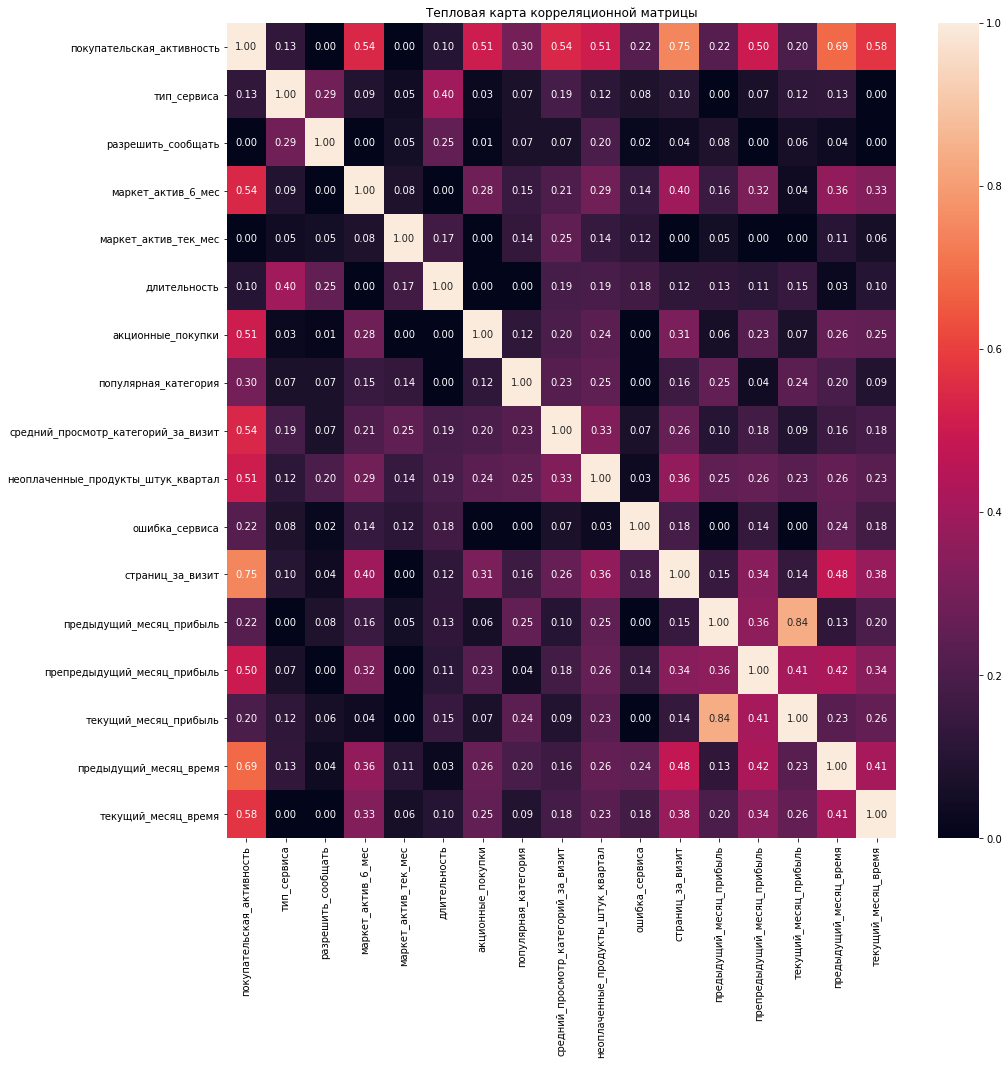

In [49]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(market_file.phik_matrix(interval_cols=market_file.select_dtypes(include='number').columns.tolist()), annot=True, fmt='.2f')
plt.title('Тепловая карта корреляционной матрицы')
plt.show()

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 5  <a class="tocSkip"></h3>
    
По результатам корреляционного анализа установлено наличие максимальной корреляционной связи между прибылью за предыдущий месяц и за текущий месяц (0,84). При этом, т.к. это значение меньше 0,9 делаем вывод об отсутствии мультиколлинеарности входных признаков. Коррелирующие признаки удалять из обучающей выборки не нужно.
</div>

## Раздел 6. Использование пайплайнов

In [50]:
# разбиваем датасет на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    market_file.drop(['покупательская_активность'], axis=1),
    market_file['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_file['покупательская_активность']
)

# создаем экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# фиксируем первое значение y_train до кодирования
y_train_first = y_train[y_train.index[0]]

# обучаем модель и трансформируем тренировочную выборку 
y_train = label_encoder.fit_transform(y_train)

# фиксируем первое значение y_test до кодирования
y_test_first = y_test[y_test.index[0]]

# трансформируем тестовую выборку
y_test = label_encoder.transform(y_test)

# проверяем кодирование
print(f'Значения "{y_train_first}" в y_train закодированы числом {y_train[0]}')
print(f'Значения "{y_test_first}" в y_test закодированы числом {y_test[0]}')

Значения "прежний_уровень" в y_train закодированы числом 0
Значения "прежний_уровень" в y_test закодированы числом 0


In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 215858 to 216030
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип_сервиса                          972 non-null    object 
 1   разрешить_сообщать                   972 non-null    object 
 2   маркет_актив_6_мес                   972 non-null    float64
 3   маркет_актив_тек_мес                 972 non-null    int64  
 4   длительность                         972 non-null    int64  
 5   акционные_покупки                    972 non-null    float64
 6   популярная_категория                 972 non-null    object 
 7   средний_просмотр_категорий_за_визит  972 non-null    int64  
 8   неоплаченные_продукты_штук_квартал   972 non-null    int64  
 9   ошибка_сервиса                       972 non-null    int64  
 10  страниц_за_визит                     972 non-null    int64  
 11  предыдущий_месяц_прибыль

In [52]:
y_train.shape

(972,)

In [53]:
# создаём списки с названиями признаков
ohe_columns = ['разрешить_сообщать','популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес',
               'маркет_актив_тек_мес',
               'длительность',
               'акционные_покупки',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'страниц_за_визит',
               'предыдущий_месяц_прибыль',
               'препредыдущий_месяц_прибыль',
               'текущий_месяц_прибыль',
               'предыдущий_месяц_время',
               'текущий_месяц_время']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='linear')],
        'models__C': [0.1, 1, 10, 100, 1000],        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

grid = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=10
)
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:')
display(grid.best_estimator_.named_steps['models'])

# print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_.round(2))

# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_test_pred = grid.predict(X_test)
proba = grid.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, proba).round(2)}')

Лучшая модель и её параметры:


LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')

Метрика ROC-AUC на тестовой выборке: 0.92


<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 6  <a class="tocSkip"></h3>

Произвел кодирование целевого признака с помощью LabelEncoder.
    
Создал пайплайн для поиска наилучшей модели с наилучшими гиперпараметрами с помощью GridSearchCV. В итоге лучшей оказалась модель с методом опорных векторов со значениями гиперпараметров C=0.1, gamma=0.1. Метрика лучшей модели на тренировочной выборке: 0.91, Метрика ROC-AUC на тестовой выборке: 0.89. Однако с такой моделью этап проверки важности признаков требует больших вычислительных мощностей и использование альтернативного оценщика. В результате сделал допущение: поменял значение kernel на linear. В итоге **лучшей моделью** пайплайн отобрал **логистическую регрессию с гиперпараметром C=1**. Метрика данной модели на тренировочной выборке: 0.9, Метрика ROC-AUC на тестовой выборке: 0.88, что в принципе практически равно метрикам на лучшей модели. Для еще большего ускорения обработки поменял способ оптимизации гиперпараметров на RandomizedSearchCV. Метрики почти не изменились, модель выбрана та же с теми же параметрами.
</div>

## Раздел 7. Анализ важности признаков

In [54]:
# подготавливаем данные для последующего анализа важности признаков
best_model = grid.best_estimator_
X_train_transformed = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_train_df = pd.DataFrame(
    X_train_transformed,
    columns=best_model.named_steps['preprocessor'].get_feature_names_out()
)
explainer = shap.LinearExplainer(best_model.named_steps['models'], X_train_df)
shap_values = explainer(X_train_df)

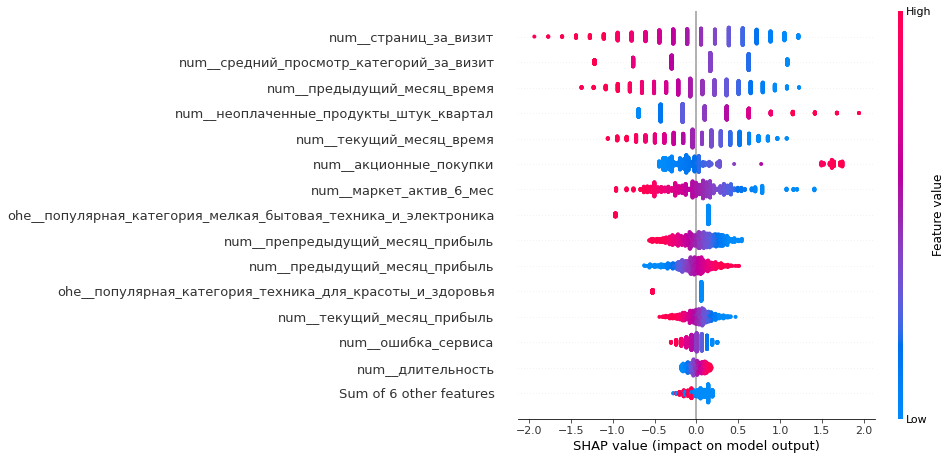

In [55]:
# строим beeswarm для оценки общей важности признаков
shap.plots.beeswarm(shap_values, max_display=15)

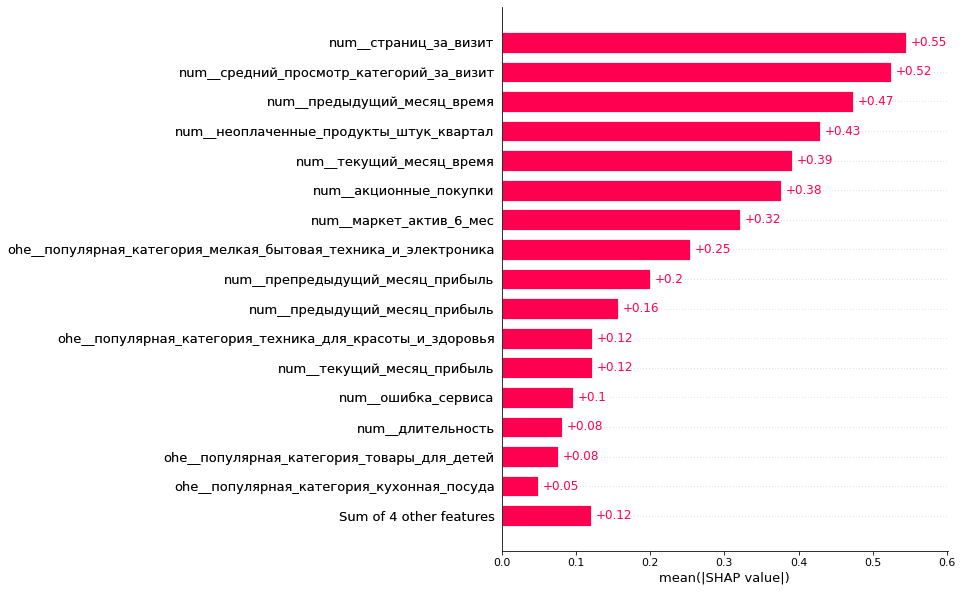

In [56]:
# строим bar для оценки агрегированного вклада признаков
shap.plots.bar(shap_values, max_display=17)

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 7  <a class="tocSkip"></h3>

Произвел анализ важности признаков. В принципе корреляционная матрица справилась тоже хорошо. Однако с помощью метода shap определены направления влияния (отрицательно или положительно). Выявлены семь самых важных признаков. (Целевой признак сохранения покупательской способности закодирован нулем, значит положительный эффект отражен на графике слева):
1. Страниц на визит, предыдущий месяц время, средний просмотр категорий за визит, текущий месяц время,  маркет активность за 6 мес имеют сильное положительное влияние на покупательскую способность.
2. Акционные покупки и неоплаченные покупки шт в квартал - имеют сильное отрицательное влияние на покупательскую способность.
3. Остальные признаки влияют на целевой показатель менее выраженно.

</div>

## Раздел 8. Сегментация покупателей

In [57]:
# добавляем к тестовым данным столбец с вероятностями отнесения событий к классу 1 (снижение активности)
X_test['proba'] = grid.predict_proba(X_test)[:,1]

# сцепляем с таблицей money
X_test = X_test.join(money)

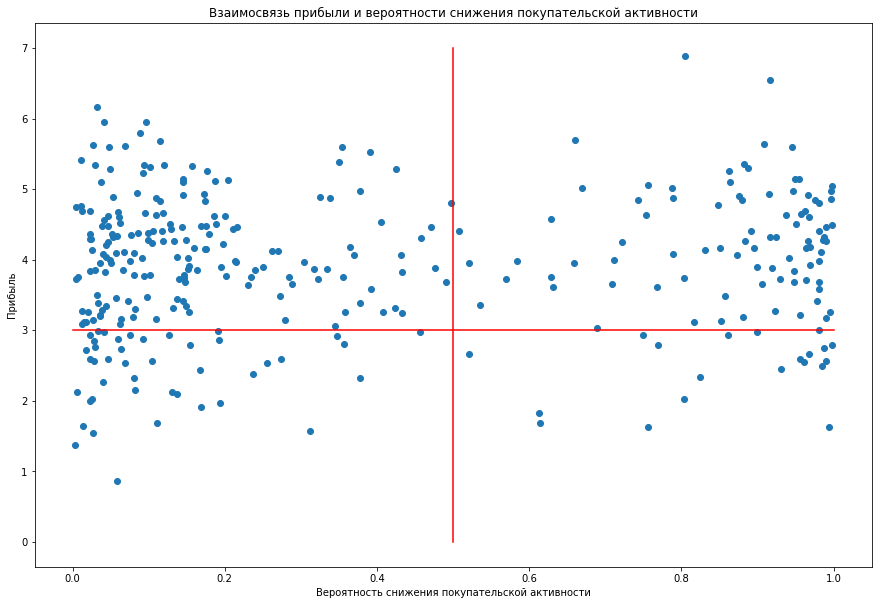

In [58]:
# строим диаграмму разброса
plt.figure(figsize=(15, 10))
fig = plt.scatter(X_test['proba'], X_test['прибыль'])
plt.title('Взаимосвязь прибыли и вероятности снижения покупательской активности')
plt.xlabel('Вероятность снижения покупательской активности')
plt.ylabel('Прибыль')

# добавляем разделительные линии
plt.plot([0,1], [3,3], 'r-')
plt.plot([0.5, 0.5], [0,7], 'r-')
plt.show()

In [59]:
# делаем срез для сегмента покупателей, приносящих большую прибыль, с высокой вероятностью снижения покупательской активности
segm = X_test.query('прибыль >=3')
segm.loc[segm['proba'] >= 0.5,'segment'] = 'сегмент'
segm.loc[segm['proba'] < 0.5,'segment'] = 'контрсегмент'
# добавляем столбец с динамикой выручки
segm['delta']= segm['текущий_месяц_прибыль'] - segm['препредыдущий_месяц_прибыль']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

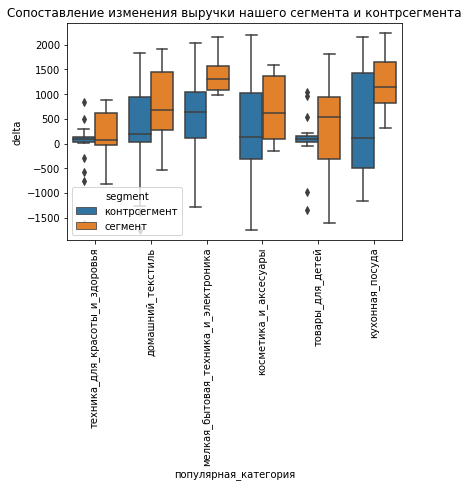

In [60]:
my_plot = sns.boxplot(data=segm, x='популярная_категория', y='delta', hue='segment')
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)
sns.set_theme(rc={'figure.figsize':(15,10)})
plt.title('Сопоставление изменения выручки нашего сегмента и контрсегмента')
plt.show()

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



редко студенты анализируют динамику продаж, поэтому жирный плюс

 

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 8  <a class="tocSkip"></h3>

Произвел сегментацию покупателей по двум признакам: вероятность падения покупательской активности более 0.5 и прибыль более 3.
Это сегмент самых прибыльных для сайта покупателей, которым нужно сделать предложения, чтобы не допустить снижения их активности.
    
По анализу изменения выручки по различным товарам по этим группам видно несколько вещей:
    
    - самые низкие показатели прироста выручки у техники для красоты и здоровья.
    - также много отрицательных значений динамики выручки есть у детских товаров.
    - чуть меньше у косметики и аксессуаров.
    
Можно сделать следующие предложения:
    
    - возможно предложить данному сегменту скидку на технику для красоты и здоровья, однако иметь ввиду, что для окончательного решения необходимы дополнительные данные по продажам данного типа товаров за более длительный срок, т.к. клиенты возможно в течение скажем года уже по-полной закупились этими товарами. Эти покупки являются долгосрочными и повторно делаются спустя большой срок. Если это подтвердится, то лучше объем возможных скидок перекинуть на другие два вида товаров.
    - предложить скидки на детские товары и косметику с аксессуарами.

</div>

## Раздел 9. Общий вывод

<div class="alert alert-block alert-info">
    
<h3> Итоговый вывод <a class="tocSkip"></h3>
    
В проекте ставилась задача разработать решение для Интернет-магазина «В один клик», которое позволит персонализировать предложения постоянным клиентам для увеличения их покупательской активности.
    
Для этого требовалось промаркировать уровень финансовой активности постоянных покупателей -  «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень». Далее собрать данные по клиентам по следующим группам:

Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
В исследование нужно было включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.

Используя данные модели и данные о прибыльности клиентов, нужно было выделить сегменты покупателей и разработать для них персонализированные предложения.
    

Импортировал необходимые библиотеки и функции, задал константы. Использовал проверку директорий, после чего **загрузил** датафреймы. При создании датафрейма из файла money.csv указывал разделитель ';', после заменил запятые на точки в столбце 'Прибыль' и поменял тип данных на float.    

**Провел предобработку данных** с использованием собственных функций. Пропусков в данных не обнаружено. Проверил категориальные столбцы на уникальные значения. Выявил ошибки, исправил их. Преобразовал датафреймы market_time и market_money: создал отдельные столбцы для каждого периода. Выявил дубликаты, но только после вывода ID в индекс, поэтому удалять их не стал. Проверил данные повторно: данные очищены.
    
**Провел исследовательский анализ данных** с помощью собственных функций. Использовал статистический и графический методы анализа. 

В файле market_file распределение гистограмм "маркет_актив_6_мес", "маркет_актив_тек_мес", "длительность", "средний_просмотр_категорий_за_визит", "неоплаченные_продукты_штук_квартал", "ошибка_сервиса" и "страниц_за_визит" являются ожидаемыми. 
   
Есть выбросы вниз для "маркет_актив_6_мес", они объяснимы: есть пользователи с низкой активностью. Удалять их не будем.
   
Выбросы вверх для "неоплаченные_продукты_штук_квартал" также объяснимы: есть пользователи с 9 и 10 неоплаченными товарами. Удалять их не будем.
  
Гистограмма "акционные покупки" имеет два пика: скорее всего есть покупатели, которые предпочитают исключительно покупки по акциям. Это реально. 
    
По результатам анализа таблицы market_money определил и удалил из всех датафреймов трех неактивных в предыдущие месяцы клиентов, а также одного клиента с выбросом вверх в текущем месяце. После этого распределение гистограмм стали ожидаемыми с близким к нормальному распределением. Значения за пределами усов не удалял.    

Распределение гистограмм в таблицах market_time и money является ожидаемым и близким к нормальному. Значения за пределами усов не удалял.  
    
**Объединил три таблицы**, предварительно переименовав совпадающие по названию столбцы. Удалил пропуски в данных (три неактивных клиента и один с выбросом вверх по прибыли за текущий месяц). Обнаружил и удалил явные дубликаты.    
    
По результатам **корреляционного анализа** установлено наличие максимальной корреляционной связи между прибылью за предыдущий месяц и за текущий месяц (0,84). При этом, т.к. это значение меньше 0,9 делаем вывод об отсутствии мультиколлинеарности входных признаков. Коррелирующие признаки удалять из обучающей выборки не стал.
    
**Создал пайплайн для поиска наилучшей модели** с наилучшими гиперпараметрами с помощью GridSearchCV. В итоге лучшей оказалась модель с методом опорных векторов со значениями гиперпараметров C=0.1, gamma=0.1. Метрика лучшей модели на тренировочной выборке: 0.91, Метрика ROC-AUC на тестовой выборке: 0.89. Однако с такой моделью этап проверки важности признаков требует больших вычислительных мощностей и использование альтернативного оценщика. В результате сделал допущение: поменял значение kernel на linear. В итоге лучшей моделью пайплайн отобрал логистическую регрессию с гиперпараметром C=1. Метрика данной модели на тренировочной выборке: 0.9, Метрика ROC-AUC на тестовой выборке: 0.88, что в принципе практически равно метрикам на лучшей модели. Для еще большего ускорения обработки поменял способ оптимизации гиперпараметров на RandomizedSearchCV. Метрики почти не изменились, модель выбрана та же с теми же параметрами.
    
Произвел **анализ важности признаков**. В принципе корреляционная матрица справилась тоже хорошо. Однако с помощью метода shap определены направления влияния (отрицательно или положительно). Выявлены семь самых важных признаков. (Целевой признак сохранения покупательской способности закодирован нулем, значит положительный эффект отражен на графике слева):
1. Страниц на визит, предыдущий месяц время, средний просмотр категорий за визит, текущий месяц время,  маркет активность за 6 мес имеют сильное положительное влияние на покупательскую способность.
2. Акционные покупки и неоплаченные покупки шт в квартал - имеют сильное отрицательное влияние на покупательскую способность.
3. Остальные признаки влияют на целевой показатель менее выраженно.
        
**Произвел сегментацию покупателей** по двум признакам: вероятность падения покупательской активности более 0.5 и прибыль более 3.
Это сегмент самых прибыльных для сайта покупателей, которым нужно сделать предложения, чтобы не допустить снижения их активности.
По анализу изменения выручки по различным товарам и общему объему выручки по этим группам видно несколько вещей:
    - самые низкие показатели прироста выручки у техники для красоты и здоровья.
    - также много отрицательных значений динамики выручки есть у детских товаров.
    - чуть меньше у косметики и аксессуаров.
    
**Cделал предложения по увеличению покупательской активности** клиентов сайта:
    
    - возможно предложить данному сегменту скидку на технику для красоты и здоровья, однако иметь ввиду, что для окончательного решения необходимы дополнительные данные по продажам данного типа товаров за более длительный срок, т.к. клиенты возможно в течение скажем года уже по-полной закупились этими товарами. Эти покупки являются долгосрочными и повторно делаются спустя большой срок. Если это подтвердится, то лучше объем возможных скидок перекинуть на другие два вида товаров.
    - предложить скидки на детские товары и косметику с аксессуарами.

</div>